# Step 1: Create Dataset

## Imports

In [1]:
from PIL import Image
import glob
from pathlib import Path
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import requests
from collections import OrderedDict

%matplotlib inline

## Load data

In [2]:
# Create Relevant Folders
!mkdir -p data/Large_Train data/Large_Test
!mkdir -p data/Med_Train data/Med_Test
!mkdir -p data/Small_Train data/Small_Test

In [3]:
%%capture
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar -O VOC2007.tar
!tar -xvf VOC2007.tar
!mv VOCdevkit/VOC2007/JPEGImages data/Raw_Images

## Preprocess/Generate images

In [4]:
# function that gets a path to the image and returns 2 cropped images sized 288x288

def crop_image(image_path):
    image = Image.open(image_path)
    width, height = image.size

    # crop top left part of the image
    left, top, right, bottom = 0,0,288,288
    crop1 = image.crop((left, top, right, bottom))

    # crop bottom right part of the image
    left, top, right, bottom = width-288,height-288,width,height
    crop2 = image.crop((left, top, right, bottom))
    
    return crop1, crop2

In [5]:
# iterate over all images and create 2 crops sized 288x288 from each image

raw_images_path = Path('data/Raw_Images/')
large_images_path = Path('data/Large_Train/')

for filename in os.listdir(raw_images_path):
    filepath = os.path.join(raw_images_path, filename)
    crop1, crop2 = crop_image(filepath) # generate cropped images
    crop1_filename = os.path.join(large_images_path, filename[:-4] + '_crop1.jpg')
    crop2_filename = os.path.join(large_images_path, filename[:-4] + '_crop2.jpg')
    crop1.save(crop1_filename) # save crop1 as 000005_crop1.jpg
    crop2.save(crop2_filename) # save crop2 as 000005_crop2.jpg

In [6]:
# function that gets a path to the 288x288 image and returns 2 resized images 144x144, 72x72

def resize_image(image_path):
    image = Image.open(image_path)
    return image.resize((144, 144)), image.resize((72, 72))

In [7]:
# Now, iterate over 288x288 images and create 144x144 and 72x72 rescaled versions of them

med_images_path = Path('data/Med_Train/')
small_images_path = Path('data/Small_Train/')

for filename in os.listdir(large_images_path):
    filepath = os.path.join(large_images_path, filename)
    img144, img72 = resize_image(filepath) # generate resized images
    img144.save(os.path.join(med_images_path, filename)) 
    img72.save(os.path.join(small_images_path, filename)) 

In [8]:
# function to move X first files from one folder to another

def move_files(source_path, dest_path, quantity):
    for filename in os.listdir(source_path):
        source_file_path = os.path.join(source_path, filename)
        dest_file_path = os.path.join(dest_path, filename)
        os.rename(source_file_path, dest_file_path) # move the file to test folder
        quantity-=1
        if quantity==0:
            break

# Create test sets: move the first 1000 images of each type into separate folders

large_test_path = Path('data/Large_Test/')
med_test_path = Path('data/Med_Test/')
small_test_path = Path('data/Small_Test/')

move_files(large_images_path, large_test_path, 1000)
move_files(med_images_path, med_test_path, 1000)
move_files(small_images_path, small_test_path, 1000)

## Dataloaders

In [9]:
data_transform = transforms.Compose(
    [
        transforms.ToTensor()
    ])

In [10]:
# define custom dataset class 

class ImageDataSet(Dataset):
    def __init__(self, folders, transform):
        self.folders = folders # tuple with 3 folders: small, medium and large images
        self.transform = transform
        self.filenames = os.listdir(folders[0]) # the filenames are the same in each folder

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        output = {}
        for folder in self.folders: # loop over 3 image folders (S/M/L)
            image_path = os.path.join(folder, self.filenames[idx])
            image = Image.open(image_path).convert("RGB")
            tensor_image = self.transform(image)
            output[str(folder)[5]] = tensor_image # add to dict with S/M/L key
        return output # return a dict with 3 images (keys: S/M/L)

In [11]:
# Create datasets
train_dataset = ImageDataSet([small_images_path, med_images_path, large_images_path], data_transform)
test_dataset = ImageDataSet([small_test_path, med_test_path, large_test_path], data_transform)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

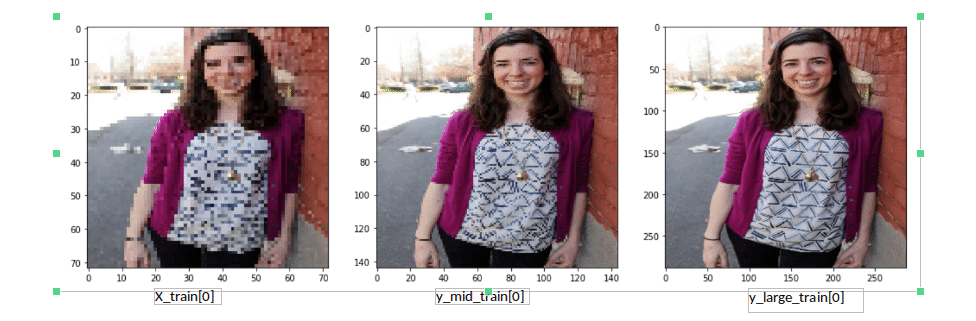

# Step 2: Create Initial Model

## Define Model

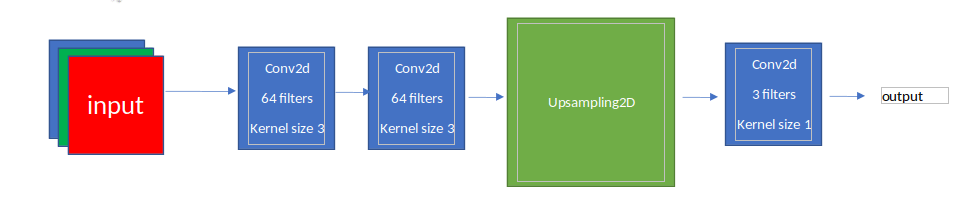

In [12]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=3, out_channels=64,
                 kernel_size=3, padding=1, padding_mode='replicate',
                 batch_norm=False, dropout=0, activation=nn.ReLU, dilation=1):
        super(ConvBlock, self).__init__(
            OrderedDict(
                [
                    ('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                                        padding=padding, padding_mode=padding_mode, dilation=dilation)),
                    # ('bn', nn.BatchNorm2d(num_features=out_channels)),
                    ('relu', activation(inplace=True)),
                    ('dropout', nn.Dropout(p=dropout)),
                ]
            )
        )


class UpsampleBlock(nn.Module):

    def __init__(self, in_channels, scale_factor=2, mode='bilinear', align_corners=False, clamp=False):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode=mode, align_corners=align_corners)
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=3,kernel_size=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.clamp = clamp

    def forward(self, x):
        out = self.upsample(x)
        img = self.conv_block(out)
        if self.clamp:
            img = torch.clamp(img, min=0., max=1.)
        return img, out

class ResidualBlock(nn.Module):

    def __init__(self, activation=nn.LeakyReLU):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            ConvBlock(32, 32, activation=activation),
            ConvBlock(32, 32, activation=activation)
        )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.block(x) + x
        return self.act(out)

In [13]:
class ModelStep2(nn.Module):

    def __init__(self, clamp=True):
        super().__init__()

        self.block = nn.Sequential(
            ConvBlock(in_channels=3, kernel_size=3, out_channels=64, activation=nn.LeakyReLU),
            ConvBlock(in_channels=64, kernel_size=3, out_channels=64, activation=nn.LeakyReLU))
        self.upsample = UpsampleBlock(in_channels=64, scale_factor=2, mode='bilinear', align_corners=False, clamp=clamp)

    def forward(self, x, return_upsampling=False):
        out = self.block(x)
        img, out = self.upsample(out)
        if return_upsampling:
            return img, out
        return img

In [14]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
model2 = ModelStep2().to(device)
print(model2)

ModelStep2(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (upsample): UpsampleBlock(
    (upsample): Upsample(scale_factor=2.0, mode=bilinear)
    (conv_block): Sequential(
      (0): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
)


In [16]:
summary(model2, (3, 72, 72))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 72, 72]           1,792
         LeakyReLU-2           [-1, 64, 72, 72]               0
           Dropout-3           [-1, 64, 72, 72]               0
            Conv2d-4           [-1, 64, 72, 72]          36,928
         LeakyReLU-5           [-1, 64, 72, 72]               0
           Dropout-6           [-1, 64, 72, 72]               0
          Upsample-7         [-1, 64, 144, 144]               0
            Conv2d-8          [-1, 3, 144, 144]             195
              ReLU-9          [-1, 3, 144, 144]               0
    UpsampleBlock-10  [[-1, 3, 144, 144], [-1, 64, 144, 144]]               0
Total params: 38,915
Trainable params: 38,915
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.06
Forward/backward pass size (MB): 629829.74
Params size (MB):

## Train Model

In [84]:
def train_model(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=5, double_output=False):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf
    train_size = len(train_dataloader.dataset)
    test_size = len(test_dataloader.dataset)

    for epoch in range(num_epochs):

        # model training
        model.train()
        running_loss = 0.0

        for dict_of_batches in train_dataloader:
            S_batch = dict_of_batches['S'].to(device)
            M_batch = dict_of_batches['M'].to(device)
            L_batch = dict_of_batches['L'].to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                if double_output:
                    M_outputs, L_outputs = model(S_batch)  # predict batch of medium images 
                    # loss is average MSE between predicted and actual Med & Large images
                    loss = (criterion(M_outputs, M_batch) + criterion(L_outputs, L_batch)) / 2
                else:
                    M_outputs = model(S_batch)             # predict batch of medium images
                    loss = criterion(M_outputs, M_batch)   # loss is delta between predicted Med images and actual M images
                loss.backward() 
                optimizer.step()
            
            running_loss += loss.item() * S_batch.size(0)
        train_epoch_loss = running_loss / train_size

        # model validation
        model.eval()   
        running_loss = 0.0

        for dict_of_batches in test_dataloader:
            S_batch = dict_of_batches['S'].to(device)
            M_batch = dict_of_batches['M'].to(device)
            L_batch = dict_of_batches['L'].to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                if double_output:
                    M_outputs, L_outputs = model(S_batch)  # predict batch of medium images 
                    # loss is average MSE between predicted and actual Med & Large images
                    loss = (criterion(M_outputs, M_batch) + criterion(L_outputs, L_batch))/2
                else:
                    M_outputs = model(S_batch)             # predict batch of medium images
                    loss = criterion(M_outputs, M_batch)   # loss is delta between predicted Med images and actual M images
            
            running_loss += loss.item() * S_batch.size(0)
        test_epoch_loss = running_loss / test_size

        # Print epoch stats
        print(f'Epoch\t {epoch} Train Loss\t {train_epoch_loss:.5f} Test Loss\t {test_epoch_loss:.5f}')       
        
        # Save the best model
        if test_epoch_loss < best_loss:
            best_loss = test_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Complete training
    print(f'Training complete. Best test loss: {best_loss:5f}')
    model.load_state_dict(best_model_wts) # return model to the best state

In [80]:
# train the model
optimizer = optim.Adam(model2.parameters(), lr=0.003)
criterion = nn.MSELoss()
train_model(model2, train_dataloader, test_dataloader, criterion, optimizer)

Epoch	 0 Train Loss	 0.00343 Test Loss	 0.00268
Epoch	 1 Train Loss	 0.00271 Test Loss	 0.00269
Epoch	 2 Train Loss	 0.00270 Test Loss	 0.00266
Epoch	 3 Train Loss	 0.00271 Test Loss	 0.00263
Epoch	 4 Train Loss	 0.00268 Test Loss	 0.00262
Training complete. Best test loss: 0.002619


## Evaluate Model

In [37]:
# each sample will be shown as a row with 5 images: 
# small (input), predicted med output, desired output, predicted large output, desired large output

def visualize_images(model, dataloader, num_images):
    model.eval()

    with torch.no_grad(): # No need to collect gradients when generating predictions
        dict_of_batches = next(iter(dataloader)) # get a batch of input images
        S_batch = dict_of_batches['S']
        M_batch = dict_of_batches['M']
        L_batch = dict_of_batches['L']
        output = model(S_batch.to(device)) # apply model and save output

        if (type(output) == tuple): # if the model returns medium and large image batches
            M_batch_pred = output[0].clip(0,1).cpu() # truncate values larger than 1 or smaller than 0
            L_batch_pred = output[1].clip(0,1).cpu() # truncate values larger than 1 or smaller than 0
            grid_columns = 5 # show 5 images: small, med_pred, med_true, large_pred, large_true

        else: # if the model returns only med batches
            M_batch_pred = output.clip(0,1).cpu() # truncate values larger than 1 or smaller than 0
            grid_columns = 3 # show only 3 images: small, med_pred, med_true
        
        f, axs = plt.subplots(num_images, grid_columns ,figsize=(30,num_images * 6))

        for index in range(num_images):
            # reshape each image into HxWx3 bytes, as required by imshow
            S_image = (S_batch[index].permute(1, 2, 0).numpy()*255).astype('uint8') 
            M_image = (M_batch[index].permute(1, 2, 0).numpy()*255).astype('uint8') 
            L_image = (L_batch[index].permute(1, 2, 0).numpy()*255).astype('uint8') 
            M_pred = (M_batch_pred[index].permute(1, 2, 0).numpy()*255).astype('uint8') 
            if grid_columns==5:
                L_pred = (L_batch_pred[index].permute(1, 2, 0).numpy()*255).astype('uint8') 
            
            # show the small image (inout)
            ax = plt.subplot(num_images, grid_columns, index*grid_columns+1)
            ax.set_title('Small Input')
            plt.imshow(S_image)
            
            # show medium model output
            ax = plt.subplot(num_images, grid_columns, index*grid_columns+2)
            ax.set_title('Model Medium Output')
            plt.imshow(M_pred)

            # show the real medium image
            ax = plt.subplot(num_images, grid_columns, index*grid_columns+3)
            ax.set_title('Desired Medium Output')
            plt.imshow(M_image)

            if grid_columns==5:
                # show large model output
                ax = plt.subplot(num_images, grid_columns, index*grid_columns+4)
                ax.set_title('Model Large Output')
                plt.imshow(L_pred)

                # show the real medium image
                ax = plt.subplot(num_images, grid_columns, index*grid_columns+5)
                ax.set_title('Desired Large Output')
                plt.imshow(L_image)

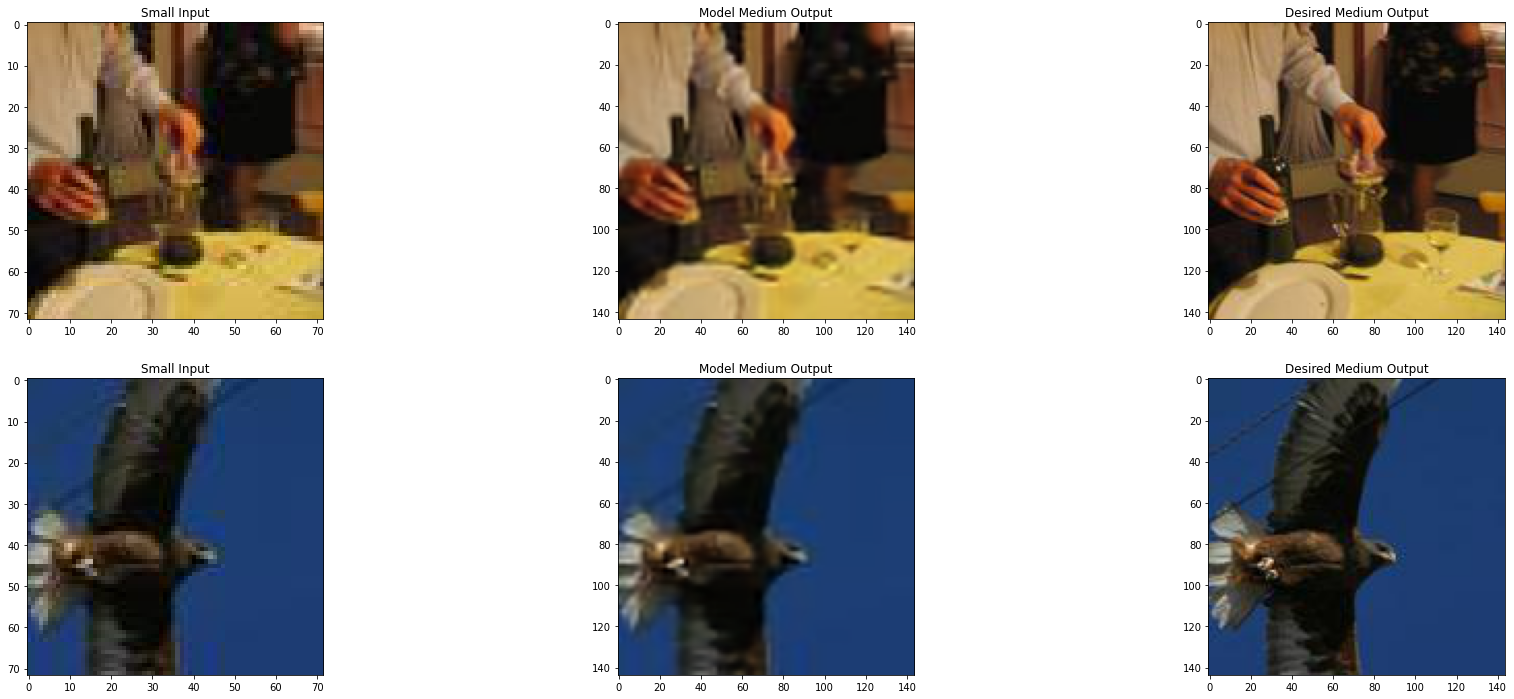

In [81]:
visualize_images(model2, train_dataloader, 2)

We can see that the model is clearly doing something - the resulting output is better than the input, but we're still very far from from good results.
Let's try better architectures.

# Step 3: Another upsampling path

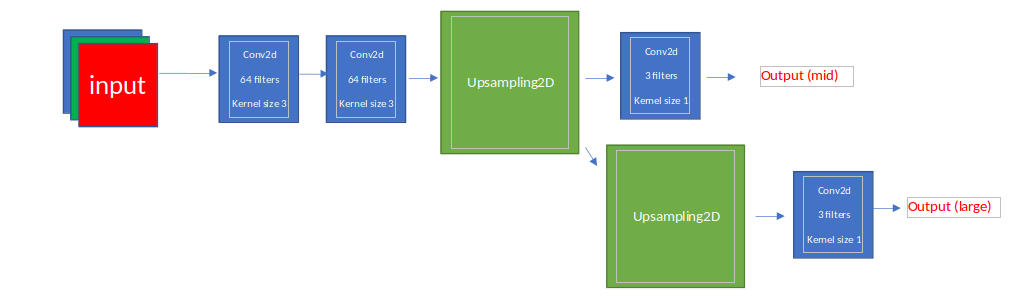

In [29]:
class ModelStep3(nn.Module):
    def __init__(self):
        super(ModelStep3, self).__init__()

        self.base_model = ModelStep2()
        self.upsample = UpsampleBlock(in_channels=64)

    def forward(self, x):
        out_mid, out = self.base_model(x, return_upsampling=True)
        out_large, _ = self.upsample(out)
        return out_mid, out_large

In [30]:
model3 = ModelStep3().to(device)
print(model3)
summary(model3, (3, 72, 72))

ModelStep3(
  (base_model): ModelStep2(
    (block): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout): Dropout(p=0, inplace=False)
      )
      (1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
        (relu): LeakyReLU(negative_slope=0.01, inplace=True)
        (dropout): Dropout(p=0, inplace=False)
      )
    )
    (upsample): UpsampleBlock(
      (upsample): Upsample(scale_factor=2.0, mode=bilinear)
      (conv_block): Sequential(
        (0): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
  )
  (upsample): UpsampleBlock(
    (upsample): Upsample(scale_factor=2.0, mode=bilinear)
    (conv_block): Sequential(
      (0): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)


In [85]:
optimizer = optim.Adam(model3.parameters(), lr=0.003)
train_model(model3, train_dataloader, test_dataloader, criterion, optimizer, double_output=True)

Epoch	 0 Train Loss	 0.00490 Test Loss	 0.00438
Epoch	 1 Train Loss	 0.00439 Test Loss	 0.00436
Epoch	 2 Train Loss	 0.00439 Test Loss	 0.00445
Epoch	 3 Train Loss	 0.00439 Test Loss	 0.00434
Epoch	 4 Train Loss	 0.00436 Test Loss	 0.00432
Training complete. Best test loss: 0.004319


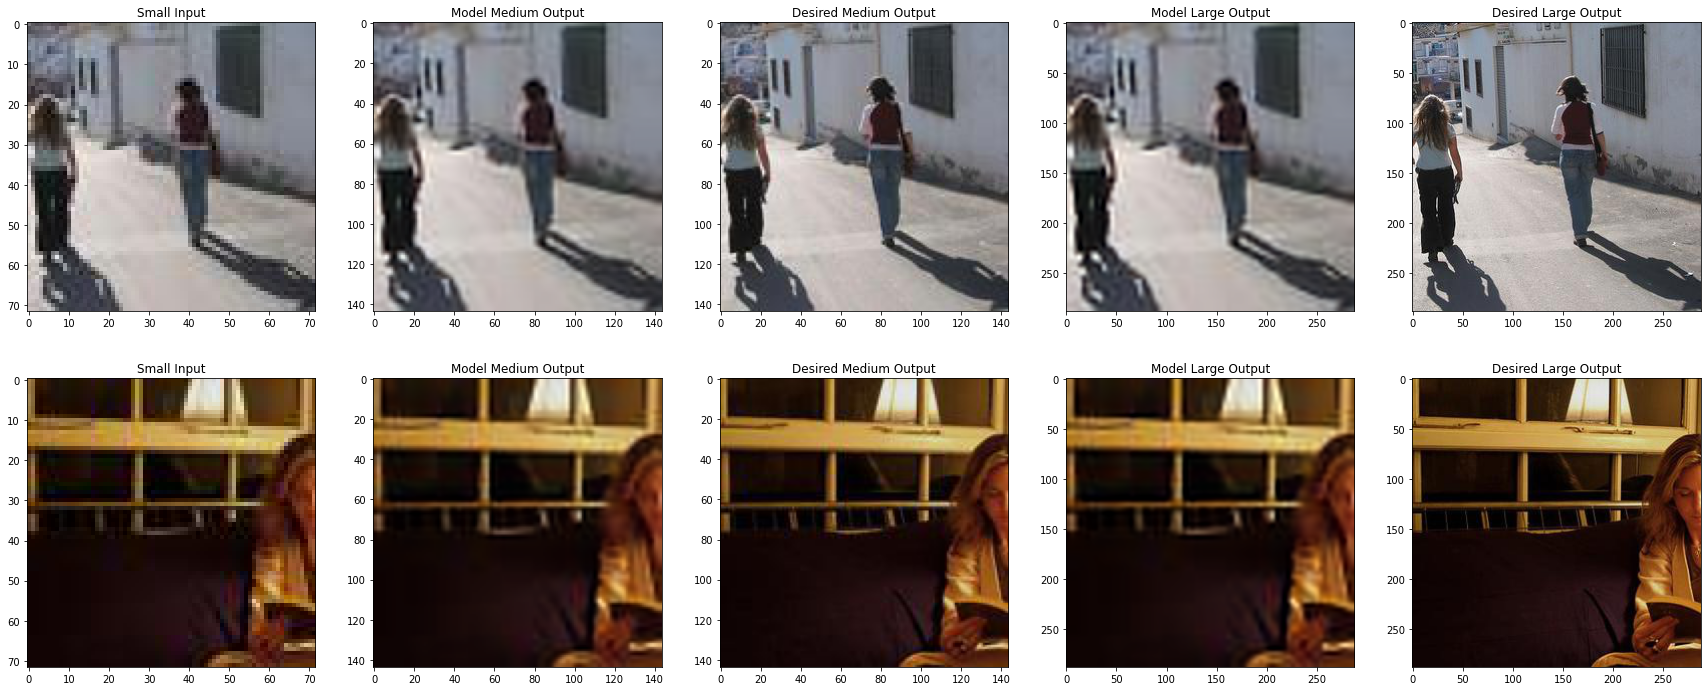

In [39]:
visualize_images(model3, train_dataloader, 2)

The large upscaled image is not better than the medium one. We clearly need a more complex model with a better architecture.

# Step 4: Add residual blocks into the process

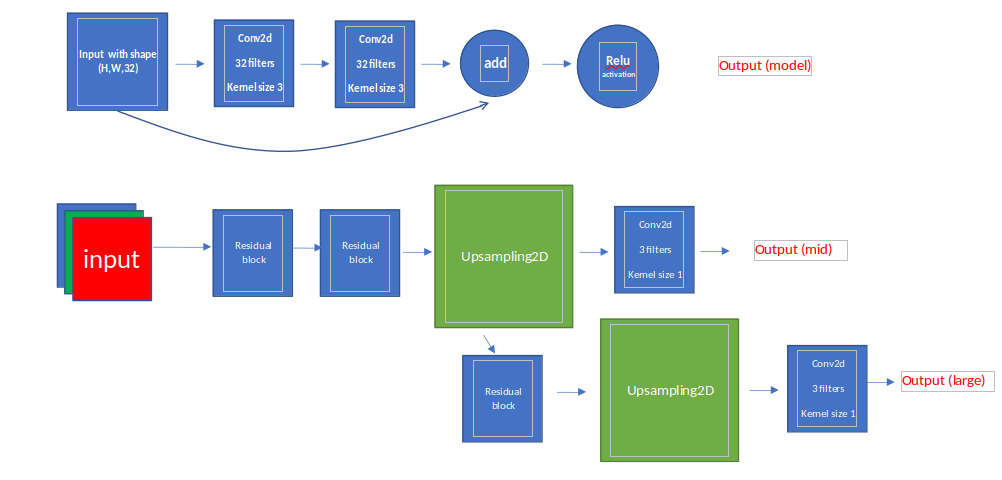

In [40]:
class ModelStep4(nn.Module):

    def __init__(self):
        super(ModelStep4, self).__init__()

        self.block = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=32, kernel_size=1, padding=0, activation=nn.LeakyReLU),
            ResidualBlock(activation=nn.LeakyReLU),
            ResidualBlock(activation=nn.LeakyReLU)
        )
        self.upsample1 = UpsampleBlock(in_channels=32)
        self.residual = ResidualBlock(activation=nn.LeakyReLU)
        self.upsample2 = UpsampleBlock(in_channels=32)

    def forward(self, x):
        out = self.block(x)
        out_mid, out = self.upsample1(out)
        out = self.residual(out)
        out_large, _ = self.upsample2(out)
        return out_mid, out_large

In [41]:
model4 = ModelStep4().to(device)
print(model4)
summary(model4, (3, 72, 72))

ModelStep4(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (1): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
          (dropout): Dropout(p=0, inplace=False)
        )
      )
      (act): ReLU()
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [86]:
optimizer = optim.Adam(model4.parameters(), lr=0.003)
train_model(model4, train_dataloader, test_dataloader, criterion, optimizer, double_output=True)

Epoch	 0 Train Loss	 0.00608 Test Loss	 0.00448
Epoch	 1 Train Loss	 0.00447 Test Loss	 0.00438
Epoch	 2 Train Loss	 0.00440 Test Loss	 0.00435
Epoch	 3 Train Loss	 0.00437 Test Loss	 0.00432
Epoch	 4 Train Loss	 0.00434 Test Loss	 0.00434
Training complete. Best test loss: 0.004323


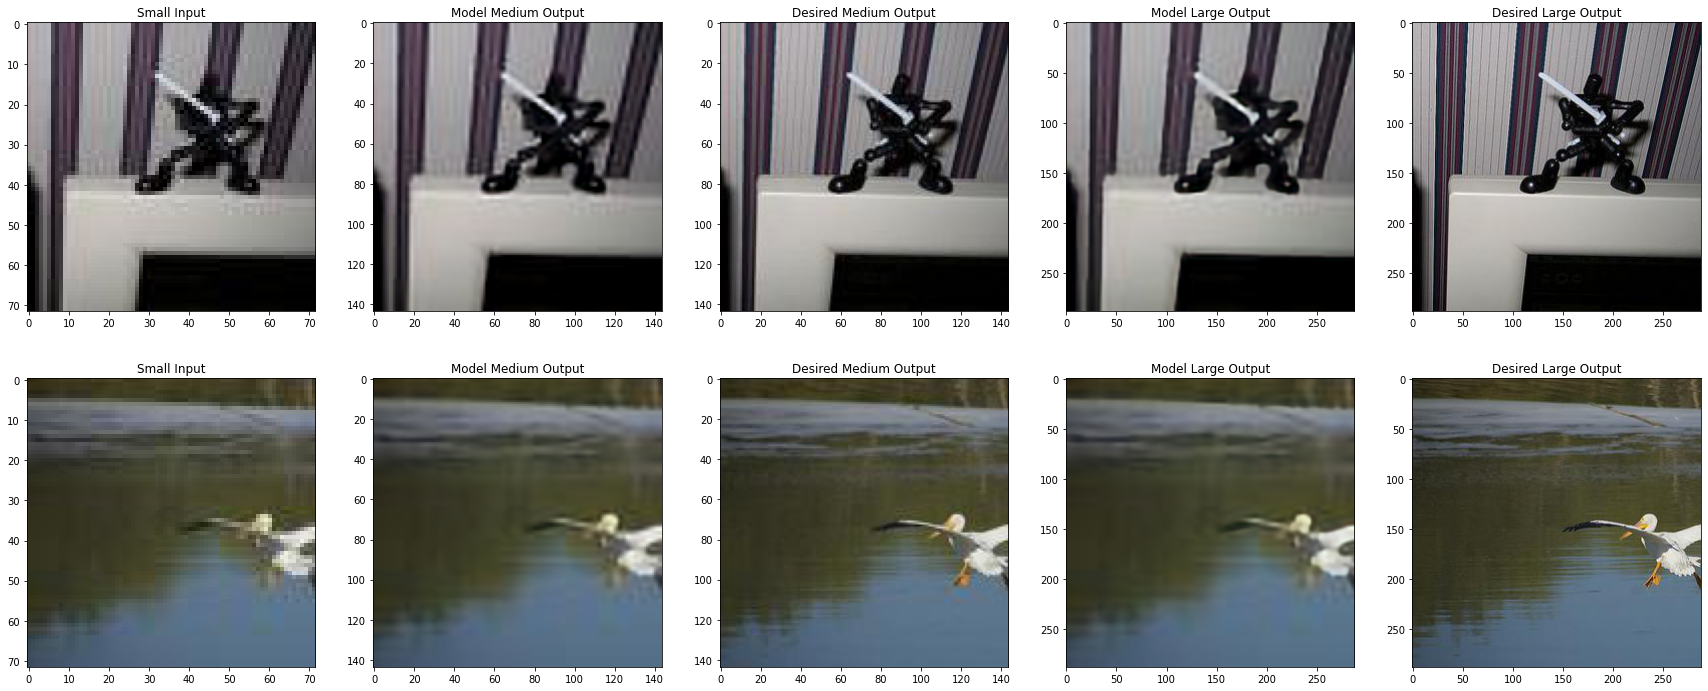

In [43]:
visualize_images(model4, train_dataloader, 2)

# Step 5: replace the residual blocks with a dilated (Atrous) convolutional block

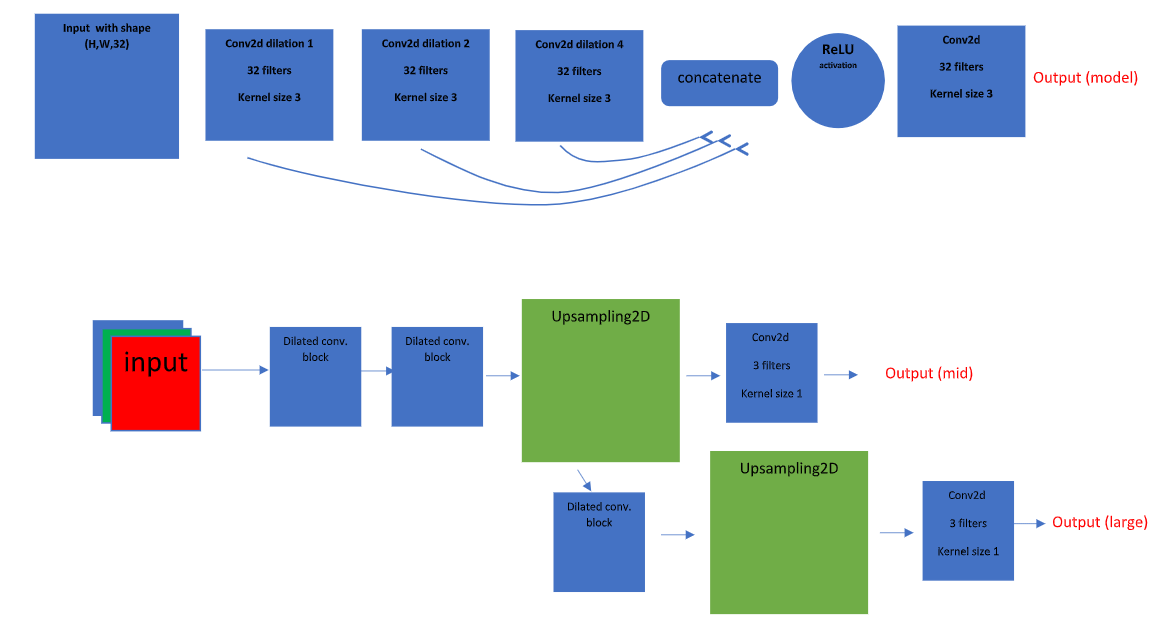

In [44]:
class DilateBlock(nn.Module):
    def __init__(self, dilations=None, activation = nn.LeakyReLU):
        super(DilateBlock, self).__init__()
        if dilations is None:
          dilations = [1, 2, 4]
        self.dilate_block = nn.ModuleList([ConvBlock(32, 32, dilation=d, padding=d, activation=activation) for d in dilations])
        self.conv_block = ConvBlock(96, 32, activation=activation)
    
    def forward(self, x):
        out = torch.cat([dilate(x) for dilate in self.dilate_block], dim=1)
        out = F.relu(self.conv_block(out))
        return out

In [45]:
class DilateModelStep5(nn.Module):
    def __init__(self):
        super(DilateModelStep5, self).__init__()
        self.block = nn.Sequential(
            # change input dimentions to 32 channels expected by dilation block
            ConvBlock(in_channels=3, out_channels=32, kernel_size=1, padding=0, activation=nn.LeakyReLU), 
            DilateBlock(), 
            DilateBlock()
        )
        self.upsample1 = UpsampleBlock(in_channels=32)
        self.dilated = DilateBlock()
        self.upsample2 = UpsampleBlock(in_channels=32)
    
    def forward(self, x):
        out = self.block(x)
        out_mid, out = self.upsample1(out)
        out = self.dilated(out)
        out_large, _ = self.upsample2(out)
        return out_mid, out_large

In [46]:
model5 = DilateModelStep5().to(device)
print(model5)
summary(model5, (3, 72, 72))

DilateModelStep5(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): DilateBlock(
      (dilate_block): ModuleList(
        (0): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (1): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), padding_mode=replicate)
          (relu): LeakyReLU(negative_slope=0.01, inplace=True)
          (dropout): Dropout(p=0, inplace=False)
        )
        (2): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4), padding_mode=replicate)
          (r

In [87]:
optimizer = optim.Adam(model5.parameters(), lr=0.003)
train_model(model5, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=10, double_output=True)

Epoch	 0 Train Loss	 0.01041 Test Loss	 0.00487
Epoch	 1 Train Loss	 0.00459 Test Loss	 0.00439
Epoch	 2 Train Loss	 0.00664 Test Loss	 0.00515
Epoch	 3 Train Loss	 0.00468 Test Loss	 0.00443
Epoch	 4 Train Loss	 0.00450 Test Loss	 0.00436
Epoch	 5 Train Loss	 0.00452 Test Loss	 0.00434
Epoch	 6 Train Loss	 0.00446 Test Loss	 0.00465
Epoch	 7 Train Loss	 0.00444 Test Loss	 0.00441
Epoch	 8 Train Loss	 0.00441 Test Loss	 0.00448
Epoch	 9 Train Loss	 0.00447 Test Loss	 0.00447
Training complete. Best test loss: 0.004339


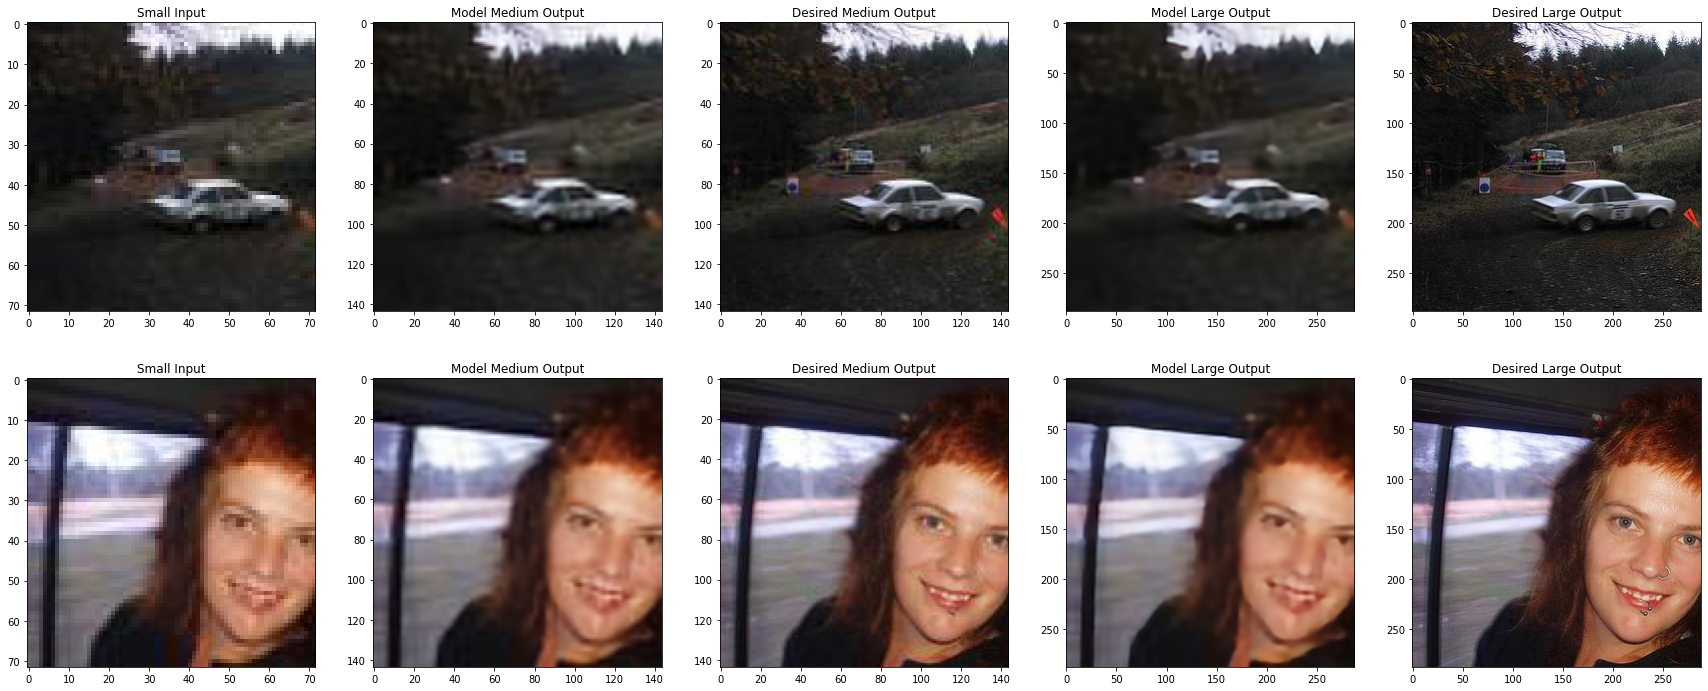

In [58]:
visualize_images(model5, train_dataloader, 2)

# Step 6: Add a pretrained network

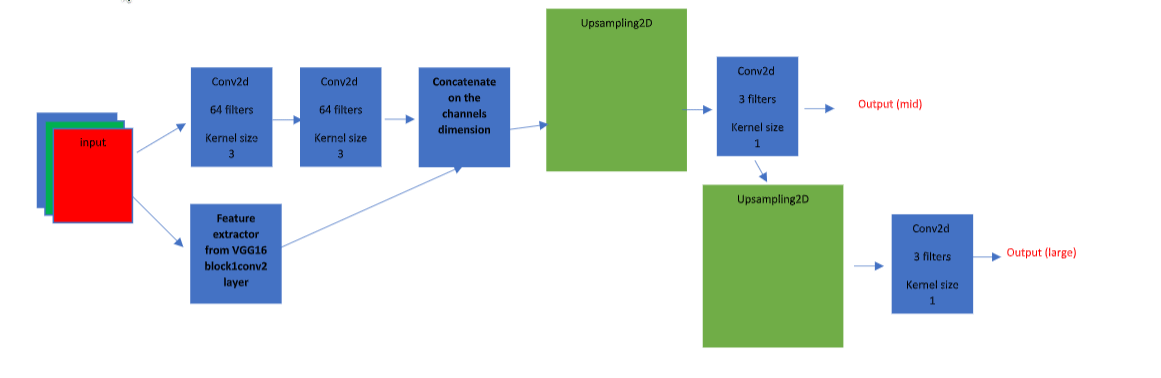

In [50]:
from torchvision import models, transforms

In [70]:
vgg16_transform = transforms.Normalize(
                          mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]
                  )

class VGG16ModelStep6(nn.Module):

    def __init__(self, clamp=True, freeze=True):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(in_channels=3, kernel_size=3, out_channels=64, activation=nn.LeakyReLU),
            ConvBlock(in_channels=64, kernel_size=3, out_channels=64, activation=nn.LeakyReLU))
        self.feature_extractor = models.vgg16(pretrained=True).features[:4] # take 4 first VGG layers (conv+relu+conv+relu)
        if freeze:
          self.__freeze_pretrained__()
        self.upsample1 = UpsampleBlock(in_channels=128, scale_factor=2, mode='bilinear', align_corners=False, clamp=clamp)
        self.upsample2 = UpsampleBlock(in_channels=3, scale_factor=2, mode='bilinear', align_corners=False, clamp=clamp)
    
    def __freeze_pretrained__(self):
      for p in self.feature_extractor.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.block(x)
        x = torch.cat([vgg16_transform(x[i]).unsqueeze(0) for i in range(x.size(0))]) # normalize input data for VGG
        out = torch.cat([out, self.feature_extractor(x)], dim=1) # concatenate convolutions with VGG features
        out_mid, _ = self.upsample1(out)
        out_large, _ = self.upsample2(out_mid)
        return out_mid, out_large

In [52]:
model6 = VGG16ModelStep6().to(device)
print(model6)
summary(model6, (3, 72, 72))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG16ModelStep6(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upsample1): UpsampleBlock(
    (upsample): Upsample(scale_factor=2.0, mode=bilinear)
    (conv_block): Sequential(
      (0): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (upsample2): UpsampleBl

In [88]:
optimizer = optim.Adam(model6.parameters(), lr=0.003)
train_model(model6, train_dataloader, test_dataloader, criterion, optimizer, double_output=True)

Epoch	 0 Train Loss	 0.00474 Test Loss	 0.00442
Epoch	 1 Train Loss	 0.00443 Test Loss	 0.00436
Epoch	 2 Train Loss	 0.00448 Test Loss	 0.00435
Epoch	 3 Train Loss	 0.00439 Test Loss	 0.00491
Epoch	 4 Train Loss	 0.00447 Test Loss	 0.00438
Training complete. Best test loss: 0.004354


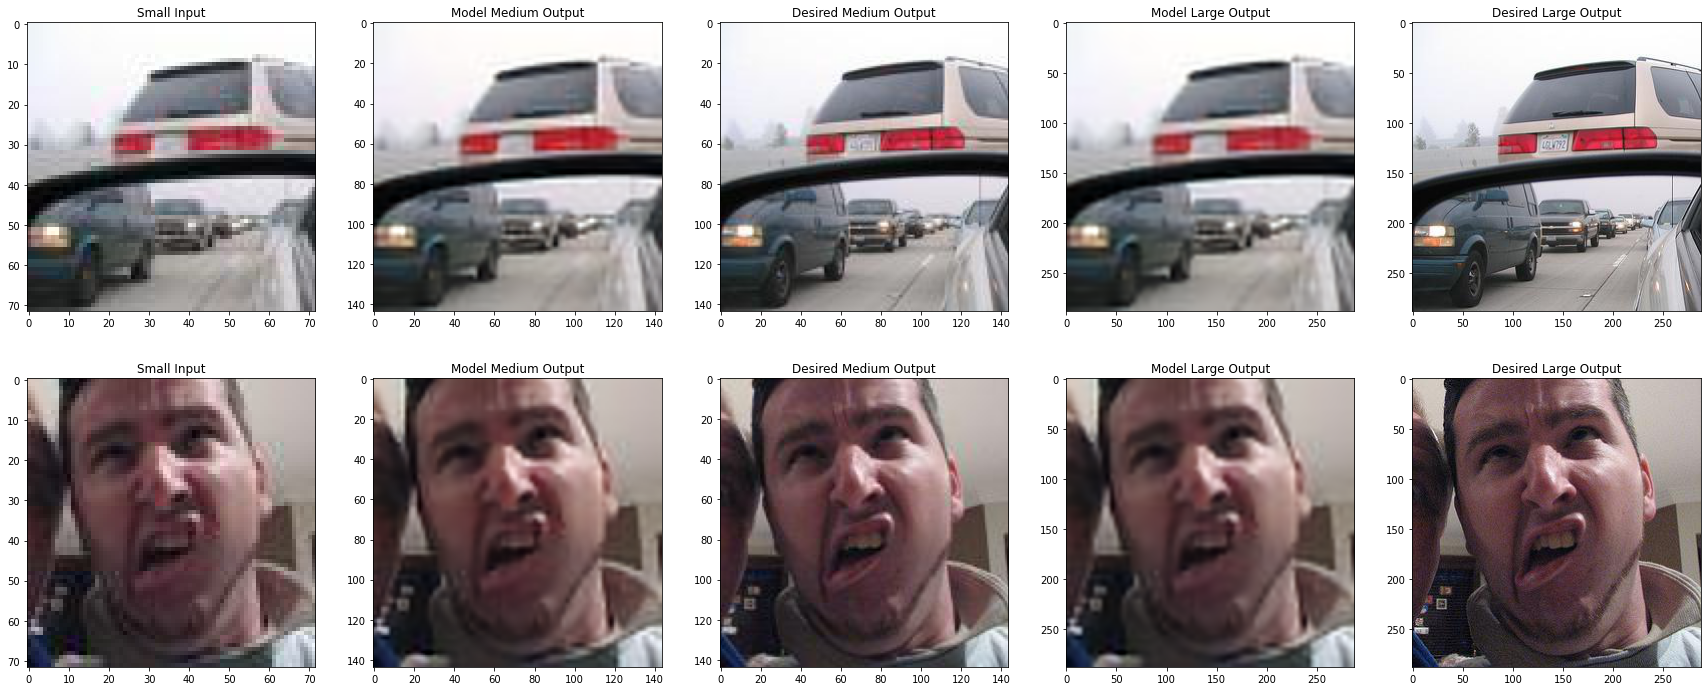

In [56]:
visualize_images(model6, train_dataloader, 2)

## Unfreeze feature extractors
Let's try the same network without freezing pre-trained feature extraction VGG layers

In [62]:
model7 = VGG16ModelStep6(freeze=False).to(device)
print(model7)
summary(model7, (3, 72, 72))

VGG16ModelStep6(
  (block): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (dropout): Dropout(p=0, inplace=False)
    )
  )
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (upsample1): UpsampleBlock(
    (upsample): Upsample(scale_factor=2.0, mode=bilinear)
    (conv_block): Sequential(
      (0): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (upsample2): UpsampleBlo

In [89]:
optimizer = optim.Adam(model7.parameters(), lr=0.003)
train_model(model7, train_dataloader, test_dataloader, criterion, optimizer, double_output=True)

Epoch	 0 Train Loss	 0.00455 Test Loss	 0.00431
Epoch	 1 Train Loss	 0.00435 Test Loss	 0.00443
Epoch	 2 Train Loss	 0.00432 Test Loss	 0.00427
Epoch	 3 Train Loss	 0.00433 Test Loss	 0.00428
Epoch	 4 Train Loss	 0.00431 Test Loss	 0.00427
Training complete. Best test loss: 0.004269


# Summary


Create a report that describes your work and compares the different results you got from the various models that you have trained.
Use both visual examples of results you got in each stage and a relevant metrics table.
Use the MSE loss for the network loss.
Although the architecture and task is different, this blog post might be useful for code examples: https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/